## Example with CNN-LSTM on live BTC close price using the full data

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.7 MB/s 
     |████████████████████████████████| 70 kB 7.8 MB/s 
     |████████████████████████████████| 288 kB 59.5 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 58.4 MB/s 
     |████████████████████████████████| 112 kB 65.9 MB/s 
     |████████████████████████████████| 94 kB 2.7 MB/s 
     |████████████████████████████████| 271 kB 50.3 MB/s 
     |████████████████████████████████| 144 kB 59.6 MB/s 
     |████████████████████████████████| 749 kB 47.1 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [4]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [5]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169607, 8)


### Generate Candles and build features from technical analysis

In [6]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()

# Generate normalized timeseries

In [7]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


[0.36655677105384166,
 0.3666259679600115,
 0.36566294733296006,
 0.36541511315059894,
 0.36435676468044237,
 0.3644716679641087,
 0.3643067790205907,
 0.3644797712860155,
 0.36507832452438516,
 0.3656624010415956]

## Train CNN-LSTM model using full data set

In [8]:
btc_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.90)
btc_model.sats2model()

In [9]:
datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')

'220624_16_46'

In [10]:
MODELDATE_TO_SAVE = datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')
PRESAVED_MODELDATE = "220624_16_16"

if PRESAVED_MODELDATE == MODELDATE_TO_SAVE :
  model_name = f"model/LSTM_CNN_pretrained_{MODELDATE_TO_SAVE}"
else:
  model_name = "model/LSTM_CNN_model"

btc_model.sats2train(model_name, epochs=20)

Epoch 1/20
11/11 [==============================] - 31s 488ms/step - loss: 0.2050 - val_loss: 0.1458
Epoch 2/20
11/11 [==============================] - 1s 102ms/step - loss: 0.0548 - val_loss: 0.0756
Epoch 3/20
11/11 [==============================] - 1s 102ms/step - loss: 0.0370 - val_loss: 0.0672
Epoch 4/20
11/11 [==============================] - 1s 104ms/step - loss: 0.0204 - val_loss: 0.0423
Epoch 5/20
11/11 [==============================] - 1s 89ms/step - loss: 0.0563 - val_loss: 0.0112
Epoch 6/20
11/11 [==============================] - 1s 89ms/step - loss: 0.0542 - val_loss: 0.0629
Epoch 7/20
11/11 [==============================] - 1s 89ms/step - loss: 0.0296 - val_loss: 0.0386
Epoch 8/20
11/11 [==============================] - 1s 101ms/step - loss: 0.0174 - val_loss: 0.0207
Epoch 9/20
11/11 [==============================] - 1s 104ms/step - loss: 0.0094 - val_loss: 0.0045
Epoch 10/20
11/11 [==============================] - 1s 102ms/step - loss: 0.0084 - val_loss: 0.0064
E

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


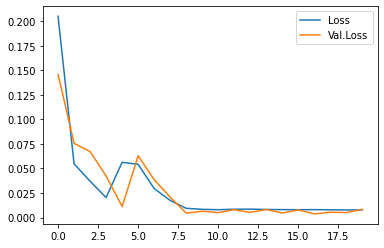

In [11]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

### Retrain for longer

In [12]:
btc_model.sats2train(model_name, epochs=100)

Epoch 1/100
11/11 [==============================] - 1s 106ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 2/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0078 - val_loss: 0.0038
Epoch 3/100
11/11 [==============================] - 1s 102ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 4/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0079 - val_loss: 0.0047
Epoch 5/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0077 - val_loss: 0.0083
Epoch 6/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0077 - val_loss: 0.0043
Epoch 7/100
11/11 [==============================] - 1s 88ms/step - loss: 0.0078 - val_loss: 0.0060
Epoch 8/100
11/11 [==============================] - 1s 88ms/step - loss: 0.0077 - val_loss: 0.0039
Epoch 9/100
11/11 [==============================] - 1s 105ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 10/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0076 - val_loss: 0.0

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


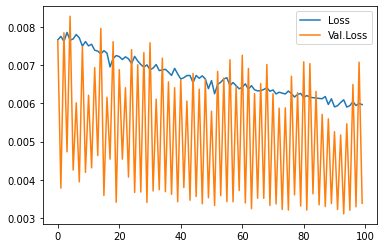

In [13]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [14]:
btc_model.sats2pred(predict_on_test = True)
btc_model.preds

array([[0.528274  ],
       [0.52805585],
       [0.52792424],
       ...,
       [0.37224418],
       [0.37220162],
       [0.37201267]], dtype=float32)

In [15]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(btc_model.scaler, ts_btc.candles, btc_model.preds)
np.array(preds)

array([38874.82579706, 38850.86572586, 38836.41112552, ...,
       21737.83657317, 21733.16239534, 21712.41009323])

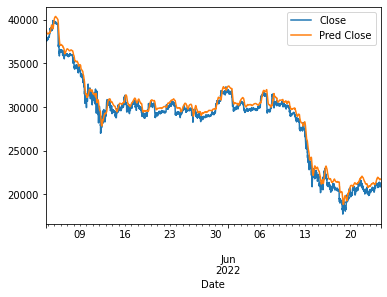

In [16]:
import src.timeutils as tu
shifted_time_indexes = tu.shift_time_index(can_btc.candles.index,1,can_btc.dtime_index)
series_predicted = tu.arr2series(preds,"Pred Close",shifted_time_indexes,top_or_bottom="bottom")
df_preds_true = tu.mergetimeseries(can_btc.candles["Close"], series_predicted)
df_preds_true.dropna().plot()

## Test on pretrained model

In [17]:
USE_PRETRAINED = False

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.90)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = True)
loaded_model.preds

array([[0.528274  ],
       [0.52805585],
       [0.52792424],
       ...,
       [0.37224418],
       [0.37220162],
       [0.37201267]], dtype=float32)

In [18]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(loaded_model.scaler, ts_btc.candles, loaded_model.preds)
np.array(preds)

array([38874.82579706, 38850.86572586, 38836.41112552, ...,
       21737.83657317, 21733.16239534, 21712.41009323])

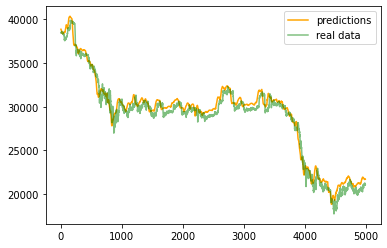

In [19]:
plt.plot(preds[0:len(ts_btc.x_candles)-loaded_model.split_point], color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point:len(ts_btc.x_candles)], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

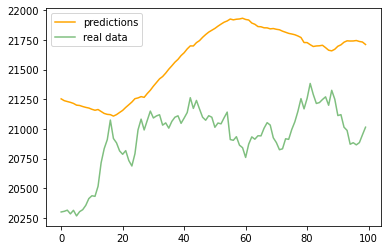

In [20]:
plt.plot(preds[-100:], color='orange', label='predictions')
plt.plot(true_vals[-100:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

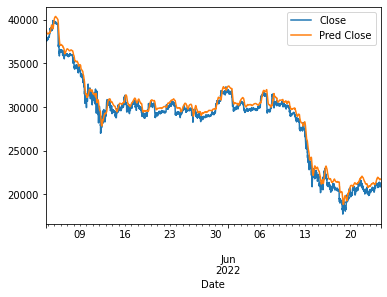

In [21]:
import src.timeutils as tu
shifted_time_indexes = tu.shift_time_index(can_btc.candles.index,1,can_btc.dtime_index)
series_predicted = tu.arr2series(preds,"Pred Close",shifted_time_indexes,top_or_bottom="bottom")
df_preds_true = tu.mergetimeseries(can_btc.candles["Close"], series_predicted)
df_preds_true.dropna().plot()

In [22]:
df_preds_true.dropna()

,Close,Pred Close
Date,,
2022-05-03 16:16:00,38161.82,38874.825797
2022-05-03 16:31:00,38183.82,38850.865726
2022-05-03 16:46:00,38149.23,38836.411126
2022-05-03 17:01:00,38168.34,38809.583702
2022-05-03 17:16:00,38225.41,38801.885056
...,...,...
2022-06-24 15:46:00,20884.17,21741.626978
2022-06-24 16:01:00,20866.06,21742.075411
2022-06-24 16:16:00,20885.06,21745.875635


Fee: 0.025
----------------------
Buy      1459 ( 849 ok 610 ko )
No-op    3537
Wallet   30572.04525
Drawback -1549.9947499999987
Total earned 30572.04525


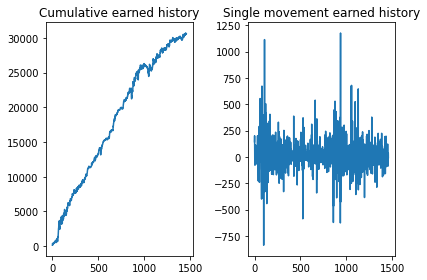

In [23]:
total_wallet_history, single_wallet_history, wallet = ts_btc.backtest(preds, true_vals, btc_model.split_point, ts_btc.step_back, fee=0.025)
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

In [72]:
def kelly_exp_returns(returns):

  drift = np.mean(returns)
  variance = np.var(returns)
  kelly_frac = drift/variance
  return kelly_frac

def kelly_exp_simple(pct_gain,pct_loss,n_wins):

  win_loss_ratio = pct_gain/pct_loss
  kelly_frac = n_wins - (1- n_wins)/win_loss_ratio
  return kelly_frac

def backtest_df(df_preds_true, long_short = "long", fee=0.025):

    if long_short != "long" and long_short != "short" and long_short != "longshort":
        raise ValueError("Can only have long, short or longshort")

    wallet = 0
    total_wallet_history = []
    single_wallet_history = []

    buys_cnt = 0
    buys_cnt_win = 0
    buys_cnt_losses = 0
    drawback = 0
    old_profit_negative = False
    old_profits = 0
    mean_pct_gain = 0
    mean_pct_loss = 0

    previous_true_close = df_preds_true.iloc[0,0]
    previous_pred_close = df_preds_true.iloc[0,-1]

    for index, row in df_preds_true.iloc[1:].iterrows():
        true_close = row[0]
        pred_close = row[-1]

        print(index,true_close, pred_close)
        print(previous_true_close,previous_pred_close)
        break

        if long_short == "long":
            if previous_true_close + previous_true_close*fee < pred_close:  # long
                profit = true_close - previous_true_close
                if profit > 0:
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                    mean_pct_gain += (true_close/previous_true_close)
                    # print(f"profit {profit}")
                    # print(f"{index}, true {true_close}, pred {pred_close}")
                    # print(f"prev true {previous_true_close}, prev pred {previous_pred_close}")                    

                else:
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    mean_pct_loss += (true_close/previous_true_close)
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

        elif long_short == "short":
            if  previous_pred_close > pred_close:  # short
                profit = -1*(true_close - previous_true_close)
                if profit > 0:
                    # win
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                    # if short we gain (i.e. mean_pct_gain >1 ) when prev close > true close
                    mean_pct_gain += (previous_true_close/true_close)
                    # print(f"profit {profit}")
                    # print(f"{index}, true {true_close}, pred {pred_close}")
                    # print(f"prev true {previous_true_close}, prev pred {previous_pred_close}")                    
                else:
                    #loss
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    #if we short we lose (i.e. mean_pct_loss < 1) when prev close < true close
                    mean_pct_loss += (previous_true_close/true_close)
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

        elif long_short == "longshort":
            if  previous_pred_close + previous_pred_close *fee > pred_close:  # short
                profit = true_close - previous_true_close
                if profit < 0:
                    # win
                    profit = -1*(profit - (profit * fee))
                    buys_cnt_win += 1
                    old_profit_negative = False
                    # if short we gain (i.e. mean_pct_gain >1 ) when prev close > true close
                    mean_pct_gain += (previous_true_close/true_close)                  
                else:
                    #loss
                    profit = -1*(profit + (profit * fee))
                    buys_cnt_losses += 1
                    #if we short we lose (i.e. mean_pct_loss < 1) when prev close < true close
                    mean_pct_loss += (previous_true_close/true_close)
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            elif previous_pred_close + previous_pred_close * fee < pred_close:  # long
                profit = true_close - previous_true_close
                if profit > 0:
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                    mean_pct_gain += (true_close/previous_true_close)
                else:
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    mean_pct_loss += (true_close/previous_true_close)
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1

        previous_true_close = true_close
        previous_pred_close = pred_close

    mean_pct_gain /= buys_cnt_win
    mean_pct_loss /= buys_cnt_losses
    
    print('Fee:', fee)
    print('----------------------')
    print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
    print('Avg PCT gain:', mean_pct_gain)
    print('Avg PCT loss:', mean_pct_loss)
    print('Wins    ', buys_cnt/len(df_preds_true))
    print('Avg Gain.   ', buys_cnt_win/buys_cnt_losses)
    print('No-op   ', len(df_preds_true) - buys_cnt)
    print('Wallet  ', wallet)
    print('Drawback', drawback)

    kelly_frac = kelly_exp_simple(mean_pct_gain,mean_pct_loss,buys_cnt_win/len(df_preds_true))

    print('Kelly Fraction   ',kelly_frac)

    return total_wallet_history, single_wallet_history, wallet, kelly_frac

In [73]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = backtest_df(df_preds_true.dropna().iloc[-4995:], long_short = "long", fee=0.025)

print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

2022-05-03 16:31:00 38183.82 38850.86572585701
38161.82 38874.8257970631


ZeroDivisionError: ignored

In [80]:
def backtest_debug(preds, true_vals, split_point, step_back, fee=0.025):


        wallet = 0
        total_wallet_history = []
        single_wallet_history = []

        buys_cnt = 0
        buys_cnt_win = 0
        buys_cnt_losses = 0
        drawback = 0
        old_profit_negative = False
        old_profits = 0

        for i in range(split_point, len(true_vals) - step_back):
            predicted_close = preds[i - split_point]
            previous_close = true_vals[i]
            real_next_close = true_vals[i+1]

            print(i,real_next_close, predicted_close)
            print(previous_close)
            break

            if (previous_close + (previous_close * fee)) < predicted_close:  # buy
                profit = real_next_close - previous_close

                if profit > 0:
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                else:
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

        print('Fee:', fee)
        print('----------------------')
        print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
#        print('No-op   ', (len(self.x_candles) - split_point) - buys_cnt)
        print('Wallet  ', wallet)
        print('Drawback', drawback)

        return total_wallet_history, single_wallet_history, wallet

44956 38465.79000000001 38874.8257970631
38481.450000000004
Fee: 0.025
----------------------
Buy      0 ( 0 ok 0 ko )
Wallet   0
Drawback 0
Total earned 0


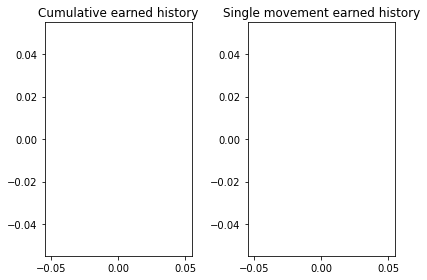

In [81]:
total_wallet_history, single_wallet_history, wallet = backtest_debug(preds, true_vals, btc_model.split_point, ts_btc.step_back, fee=0.025)
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

In [89]:
(len(np.array(true_vals))-48)*0.1

4995.200000000001

In [87]:
len(np.array(true_vals))
len(np.array(preds))

4996

In [70]:
df_preds_true.iloc[-50001:]

,Close,Pred Close
Date,,
2021-01-19 04:46:00,36284.71,NaN
2021-01-19 05:01:00,36370.04,NaN
2021-01-19 05:16:00,36472.01,NaN
2021-01-19 05:31:00,36226.87,NaN
2021-01-19 05:46:00,36251.18,NaN
...,...,...
2022-06-24 16:01:00,20866.06,21742.075411
2022-06-24 16:16:00,20885.06,21745.875635
2022-06-24 16:31:00,20950.80,21737.836573
